In [152]:
import pandas as pd
from finance_byu import fama_macbeth
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def fama(data, control):

    comb = []
    tickers = data.columns

    for i in range(len(tickers)):
        data[tickers[i]].index = pd.to_datetime(data[tickers[i]].index)
        combined = pd.concat([data[tickers[i]].rename('future'), control[i]], axis = 1)

        comb.append(combined)

    for i in range(len(comb)):
        comb[i] = comb[i].reset_index()
        comb[i]['Unnamed: 0'] = pd.to_datetime(pd.to_datetime(comb[i]['Unnamed: 0']).dt.strftime('%Y-%m'))

    results = []
    sum = []
    tickers = data.columns        

    for i in range(len(comb)):
        xvar = []
        comb[i] = comb[i].dropna(axis = 1, how = 'all')
        comb[i] = comb[i].dropna(axis = 0, how = 'any')
        for j in range(2, len(comb[i].columns)):
            xvar.append(comb[i].columns[j])
        comb[i] = comb[i].dropna(axis = 1, how = 'all')
        comb[i] = comb[i].dropna(axis = 0, how = 'any')
        reg = fama_macbeth.fama_macbeth(comb[i], t = 'Unnamed: 0', yvar = 'future', xvar = xvar, intercept = True)
        sum.append(fama_macbeth.fm_summary(reg, pvalues = True))
        results.append(fama_macbeth.fama_macbeth_master(comb[i], t = 'Unnamed: 0', yvar = 'future', xvar = xvar, intercept = True))

    return results, sum

In [153]:
ret = pd.read_csv('Final Variables/monthly_returns.csv')
abpr = pd.read_csv('Final Variables/abnormal_positive_ratio.csv')
abnr = pd.read_csv('Final Variables/abnormal_negative_ratio.csv')
ret_co_m = pd.read_csv('variable_results/sp500/filtered_ret_co_m.csv')
ret_oc_m = pd.read_csv('variable_results/sp500/filtered_ret_oc_m.csv')
size = pd.read_csv('Final Variables/monthly_size.csv')
bm = pd.read_csv('variable_results/sp500/log_monthly_bm.csv')
ret_6m = pd.read_csv('Final Variables/monthly_cum_sum.csv')
gpa = pd.read_csv('Final Variables/annual_gross_profit.csv')
atgth = pd.read_csv('variable_results/sp500/filtered_monthly_asset_growth.csv')
turn_m = pd.read_csv('variable_results/sp500/log_monthly_turnover.csv')
illiq_m = pd.read_csv('variable_results/sp500/filtered_illiquidity.csv')

def correct_format(var):
    var['Unnamed: 0'] = pd.to_datetime(pd.to_datetime(var['Unnamed: 0']).dt.strftime('%Y-%m'))
    var = var.set_index('Unnamed: 0')
    var = var.reindex(sorted(var.columns), axis=1)
    return var

ret = correct_format(ret)
abpr = correct_format(abpr)
abnr = correct_format(abnr)
ret_co_m = correct_format(ret_co_m)
ret_oc_m = correct_format(ret_oc_m)
size = correct_format(size)
size = np.log(size)
bm = correct_format(bm)
ret_6m = correct_format(ret_6m)
gpa = correct_format(gpa)
atgth = atgth.rename(columns = {'Date' : 'Unnamed: 0'})
atgth = correct_format(atgth)
turn_m = turn_m.rename(columns = {'Date' : 'Unnamed: 0'})
turn_m = correct_format(turn_m)
illiq_m = illiq_m.rename(columns = {'index' : 'Unnamed: 0'})
illiq_m = correct_format(illiq_m)['2014-01-01' : '2022-12-13']
illiq_m = illiq_m.replace(0.0, np.float64('nan'))
illiq_m = np.log(illiq_m)

fix = ['MTCH', 'WBD']
for ticker in fix:
    for i in range(len(turn_m[ticker])):
        if turn_m[ticker][i] == '--':
            turn_m[ticker][i] = np.float64('nan')
        else:
            turn_m[ticker][i] = np.log(np.float64(turn_m[ticker][i]))
    turn_m[ticker] = turn_m[ticker].astype(float)


dep = ret.shift(-1)

controls1 = []
controls2 = []
controls3 = []
controls4 = []
controls5 = []

for ticker in ret_co_m:
    data1 = pd.DataFrame()
    data1['ABNR'] = abnr[ticker]
    data1['ABPR'] = abpr[ticker]
    data1['close to open'] = ret_co_m[ticker]
    data1['open to close'] = ret_oc_m[ticker]
    controls1.append(data1)
    data2 = pd.DataFrame()
    data2['size'] = size[ticker]
    data2['bm'] = bm[ticker]
    data2['ret_6m'] = ret_6m[ticker]
    data2 = pd.concat([data1, data2], axis = 1)
    controls2.append(data2)
    data3 = pd.DataFrame()
    data3['gpa'] = gpa[ticker]
    data3['atgth'] = atgth[ticker]
    data3 = pd.concat([data2, data3], axis = 1)
    controls3.append(data3)
    data4 = pd.DataFrame()
    data4['turn_m'] = turn_m[ticker]
    data4['illiq_m'] = illiq_m[ticker]
    data4 = pd.concat([data3, data4], axis = 1)
    controls4.append(data4)
    data5 = data4.drop(['ABNR', 'ABPR'], axis = 1)
    controls5.append(data5)

In [144]:
reg1r, reg1s = fama(dep, controls1)
reg2r, reg2s = fama(dep, controls2)
reg3r, reg3s = fama(dep, controls3)
reg4r, reg4s = fama(dep, controls4)
reg5r, reg5s = fama(dep, controls5)

In [145]:
ABNR = []
ABPR = []
RET_CO_M = []
RET_OC_M = []

for i in range(len(reg1r)):
    ABNR.append(reg1r[i]['ABNR'])
    ABPR.append(reg1r[i]['ABPR'])
    RET_CO_M.append(reg1r[i]['close to open'])
    RET_OC_M.append(reg1r[i]['open to close'])

int = []
pval_1 = []
pval_2 = []
pval_3 = []
pval_4 = []
for i in range(len(reg1s)):
    int.append(reg1s[i]['mean'][0])
    pval_1.append(reg1s[i]['pval'][1])
    pval_2.append(reg1s[i]['pval'][2])
    pval_3.append(reg1s[i]['pval'][3])
    pval_4.append(reg1s[i]['pval'][4])

d = {'Intercept' : int, 'ABNR' : ABNR, 'ABPR' : ABPR, 
     'RET_CO_M' : RET_CO_M, 'RET_OC_M' : RET_OC_M}
d_p = {'ABNR' : pval_1, 'ABPR' : pval_2, 
     'RET_CO_M' : pval_3, 'RET_OC_M' : pval_4}

result1 = np.mean(pd.DataFrame(data = d))
results1p = np.mean(pd.DataFrame(data = d_p))

In [146]:
ABNR = []
ABPR = []
RET_CO_M = []
RET_OC_M = []
size = []
bm = []
ret_6m = []

for i in range(len(reg2r)):
    ABNR.append(reg2r[i]['ABNR'])
    ABPR.append(reg2r[i]['ABPR'])
    RET_CO_M.append(reg2r[i]['close to open'])
    RET_OC_M.append(reg2r[i]['open to close'])
    size.append(reg2r[i]['size'])
    if 'bm' in reg2r[i].columns:
        bm.append(reg2r[i]['bm'])
    ret_6m.append(reg2r[i]['ret_6m'])

int = []
pval_1 = []
pval_2 = []
pval_3 = []
pval_4 = []
pval_5 = []
pval_6 = []
pval_7 = []
for i in range(len(reg2s)):
    int.append(reg2s[i]['mean'][0])
    pval_1.append(reg2s[i]['pval'][1])
    pval_2.append(reg2s[i]['pval'][2])
    pval_3.append(reg2s[i]['pval'][3])
    pval_4.append(reg2s[i]['pval'][4])
    pval_5.append(reg2s[i]['pval'][5])
    if 'bm' in reg2r[i].columns:
        pval_6.append(reg2s[i]['pval'][6])
        pval_7.append(reg2s[i]['pval'][7])
    else:
        pval_7.append(reg2s[i]['pval'][6])
    
fac = len(int) - len(bm)
for i in range(fac):
    bm.append(np.float64('nan'))
    pval_6.append(np.float64('nan'))

d = {'Intercept' : int, 'ABNR' : ABNR, 'ABPR' : ABPR, 'RET_CO_M' : RET_CO_M, 
     'RET_OC_M' : RET_OC_M, 'SIZE' : size, 'BM' : bm, 'RET_6M' : ret_6m}
d_p = {'ABNR' : pval_1, 'ABPR' : pval_2, 'RET_CO_M' : pval_3, 'RET_OC_M' : pval_4,
       'SIZE' : pval_5, 'BM' : pval_6, 'RET_6M' : pval_7}

result2 = np.mean(pd.DataFrame(data = d))
results2p = np.mean(pd.DataFrame(data = d_p))

In [147]:
ABNR = []
ABPR = []
RET_CO_M = []
RET_OC_M = []
size = []
bm = []
ret_6m = []
gpa = []
atgth = []

for i in range(len(reg3r)):
    ABNR.append(reg3r[i]['ABNR'])
    ABPR.append(reg3r[i]['ABPR'])
    RET_CO_M.append(reg3r[i]['close to open'])
    RET_OC_M.append(reg3r[i]['open to close'])
    size.append(reg3r[i]['size'])
    if 'bm' in reg3r[i].columns:
        bm.append(reg3r[i]['bm'])
    ret_6m.append(reg3r[i]['ret_6m'])
    gpa.append(reg3r[i]['gpa'])
    atgth.append(reg3r[i]['atgth'])

int = []
pval_1 = []
pval_2 = []
pval_3 = []
pval_4 = []
pval_5 = []
pval_6 = []
pval_7 = []
pval_8 = []
pval_9 = []
for i in range(len(reg3s)):
    int.append(reg3s[i]['mean'][0])
    pval_1.append(reg3s[i]['pval'][1])
    pval_2.append(reg3s[i]['pval'][2])
    pval_3.append(reg3s[i]['pval'][3])
    pval_4.append(reg3s[i]['pval'][4])
    pval_5.append(reg3s[i]['pval'][5])
    if 'bm' in reg3r[i].columns:
        pval_6.append(reg3s[i]['pval'][6])
        pval_7.append(reg3s[i]['pval'][7])
        pval_8.append(reg3s[i]['pval'][8])
        pval_9.append(reg3s[i]['pval'][9])
    else:
        pval_7.append(reg3s[i]['pval'][6])
        pval_8.append(reg3s[i]['pval'][7])
        pval_9.append(reg3s[i]['pval'][8])
    
fac = len(int) - len(bm)
for i in range(fac):
    bm.append(np.float64('nan'))
    pval_6.append(np.float64('nan'))

d = {'Intercept' : int, 'ABNR' : ABNR, 'ABPR' : ABPR, 'RET_CO_M' : RET_CO_M, 'RET_OC_M' : RET_OC_M, 
     'SIZE' : size, 'BM' : bm, 'RET_6M' : ret_6m, 'GPA' : gpa, 'ATGTH' : atgth}
d_p = {'ABNR' : pval_1, 'ABPR' : pval_2, 'RET_CO_M' : pval_3, 'RET_OC_M' : pval_4, 'SIZE' : pval_5, 
       'BM' : pval_6, 'RET_6M' : pval_7, 'GPA' : pval_8, 'ATGTH' : pval_9}

result3 = np.mean(pd.DataFrame(data = d))
results3p = np.mean(pd.DataFrame(data = d_p))

In [148]:
ABNR = []
ABPR = []
RET_CO_M = []
RET_OC_M = []
size = []
bm = []
ret_6m = []
gpa = []
atgth = []
turn_m = []
illiq_m = []

for i in range(len(reg4r)):
    ABNR.append(reg4r[i]['ABNR'])
    ABPR.append(reg4r[i]['ABPR'])
    RET_CO_M.append(reg4r[i]['close to open'])
    RET_OC_M.append(reg4r[i]['open to close'])
    size.append(reg4r[i]['size'])
    if 'bm' in reg4r[i].columns:
        bm.append(reg4r[i]['bm'])
    ret_6m.append(reg4r[i]['ret_6m'])
    gpa.append(reg4r[i]['gpa'])
    atgth.append(reg4r[i]['atgth'])
    turn_m.append(reg4r[i]['turn_m'])
    if 'illiq_m' in reg4r[i].columns:
        illiq_m.append(reg4r[i]['illiq_m'])

int = []
pval_1 = []
pval_2 = []
pval_3 = []
pval_4 = []
pval_5 = []
pval_6 = []
pval_7 = []
pval_8 = []
pval_9 = []
pval_10 = []
pval_11 = []
for i in range(len(reg4s)):
    int.append(reg4s[i]['mean'][0])
    pval_1.append(reg4s[i]['pval'][1])
    pval_2.append(reg4s[i]['pval'][2])
    pval_3.append(reg4s[i]['pval'][3])
    pval_4.append(reg4s[i]['pval'][4])
    pval_5.append(reg4s[i]['pval'][5])
    if 'bm' in reg4r[i].columns:
        pval_6.append(reg4s[i]['pval'][6])
        pval_7.append(reg4s[i]['pval'][7])
        pval_8.append(reg4s[i]['pval'][8])
        pval_9.append(reg4s[i]['pval'][9])
        pval_10.append(reg4s[i]['pval'][10])
        if 'illiq_m' in reg4r[i].columns:
            pval_11.append(reg4s[i]['pval'][11])
    else:
        pval_7.append(reg4s[i]['pval'][6])
        pval_8.append(reg4s[i]['pval'][7])
        pval_9.append(reg4s[i]['pval'][8])
        pval_10.append(reg4s[i]['pval'][9])
        if 'illiq_m' in reg4r[i].columns:
            pval_11.append(reg4s[i]['pval'][10])

facbm = len(int) - len(bm)
for i in range(facbm):
    bm.append(np.float64('nan'))
    pval_6.append(np.float64('nan'))
facil = len(int) - len(illiq_m)
for i in range(facil):
    illiq_m.append(np.float64('nan'))
    pval_11.append(np.float64('nan'))

d = {'Intercept' : int, 'ABNR' : ABNR, 'ABPR' : ABPR, 'RET_CO_M' : RET_CO_M, 'RET_OC_M' : RET_OC_M,  'SIZE' : size, 
     'BM' : bm, 'RET_6M' : ret_6m, 'GPA' : gpa, 'ATGTH' : atgth, 'TURN_M' : turn_m, 'ILLIQ_M' : illiq_m}
d_p = {'ABNR' : pval_1, 'ABPR' : pval_2, 'RET_CO_M' : pval_3, 'RET_OC_M' : pval_4, 'SIZE' : pval_5, 
       'BM' : pval_6, 'RET_6M' : pval_7, 'GPA' : pval_8, 'ATGTH' : pval_9, 'TURN_M' : pval_10, 'ILLIQ_M' : pval_11}

result4 = np.mean(pd.DataFrame(data = d))
results4p = np.mean(pd.DataFrame(data = d_p))

In [149]:
RET_CO_M = []
RET_OC_M = []
size = []
bm = []
ret_6m = []
gpa = []
atgth = []
turn_m = []
illiq_m = []

for i in range(len(reg5r)):
    RET_CO_M.append(reg5r[i]['close to open'])
    RET_OC_M.append(reg5r[i]['open to close'])
    size.append(reg5r[i]['size'])
    if 'bm' in reg5r[i].columns:
        bm.append(reg5r[i]['bm'])
    ret_6m.append(reg5r[i]['ret_6m'])
    gpa.append(reg5r[i]['gpa'])
    atgth.append(reg5r[i]['atgth'])
    turn_m.append(reg5r[i]['turn_m'])
    if 'illiq_m' in reg5r[i].columns:
        illiq_m.append(reg5r[i]['illiq_m'])

int = []
pval_1 = []
pval_2 = []
pval_3 = []
pval_4 = []
pval_5 = []
pval_6 = []
pval_7 = []
pval_8 = []
pval_9 = []
for i in range(len(reg5s)):
    int.append(reg5s[i]['mean'][0])
    pval_1.append(reg5s[i]['pval'][1])
    pval_2.append(reg5s[i]['pval'][2])
    pval_3.append(reg5s[i]['pval'][3])
    if 'bm' in reg5r[i].columns:
        pval_4.append(reg5s[i]['pval'][4])
        pval_5.append(reg5s[i]['pval'][5])
        pval_6.append(reg5s[i]['pval'][6])
        pval_7.append(reg5s[i]['pval'][7])
        pval_8.append(reg5s[i]['pval'][8])
        if 'illiq_m' in reg5r[i].columns:
            pval_9.append(reg5s[i]['pval'][9])
    else:
        pval_5.append(reg5s[i]['pval'][4])
        pval_6.append(reg5s[i]['pval'][5])
        pval_7.append(reg5s[i]['pval'][6])
        pval_8.append(reg5s[i]['pval'][7])
        if 'illiq_m' in reg5r[i].columns:
            pval_9.append(reg5s[i]['pval'][8])

facbm = len(int) - len(bm)
for i in range(facbm):
    bm.append(np.float64('nan'))
    pval_4.append(np.float64('nan'))
facil = len(int) - len(illiq_m)
for i in range(facil):
    illiq_m.append(np.float64('nan'))
    pval_9.append(np.float64('nan'))

d = {'Intercept' : int, 'RET_CO_M' : RET_CO_M, 'RET_OC_M' : RET_OC_M,  'SIZE' : size, 'BM' : bm, 
     'RET_6M' : ret_6m, 'GPA' : gpa, 'ATGTH' : atgth, 'TURN_M' : turn_m, 'ILLIQ_M' : illiq_m}
d_p = {'RET_CO_M' : pval_1, 'RET_OC_M' : pval_2, 'SIZE' : pval_3, 'BM' : pval_4, 
       'RET_6M' : pval_5, 'GPA' : pval_6, 'ATGTH' : pval_7, 'TURN_M' : pval_8, 'ILLIQ_M' : pval_9}

result5 = np.mean(pd.DataFrame(data = d))
results5p = np.mean(pd.DataFrame(data = d_p))

In [150]:
final = pd.concat([result1.rename('RET(1)'), result2.rename('RET(1)'), result3.rename('RET(1)'), 
                   result4.rename('RET(1)'), result5.rename('RET(1)')], axis = 1)
final = final.replace(np.nan, '')
final.style.set_caption("Fama Macbeth Coefficients")

finalp = pd.concat([results1p.rename('RET(1)'), results2p.rename('RET(1)'), results3p.rename('RET(1)'), 
                   results4p.rename('RET(1)'), results5p.rename('RET(1)')], axis = 1)
finalp = finalp.replace(np.nan, '')
finalp.style.set_caption("Fama Macbeth Coefficient p values")

final.to_csv('Regression/reg_results.csv')
finalp.to_csv('Regression/reg_p_vals.csv')

In [154]:
x1 = np.mean(abnr, axis = 1)
x2 = np.mean(abpr, axis = 1)
x3 = np.mean(ret_co_m, axis = 1)
x4 = np.mean(ret_oc_m, axis = 1)
x5 = np.mean(size, axis = 1)
x6 = np.mean(bm, axis = 1)
x7 = np.mean(ret_6m, axis = 1)
x8 = np.mean(gpa, axis = 1)
x9 = np.mean(atgth, axis = 1)
x10 = np.mean(turn_m, axis = 1)
x11 = np.mean(illiq_m, axis = 1)

r1 = result1.values[1]*x1+result1.values[2]*x2+result1.values[3]*x3+result1.values[4]*x4
r2 = result2.values[1]*x1+result2.values[2]*x2+result2.values[3]*x3+result2.values[4]*x4+result2.values[5]*x5+result2.values[6]*x6+result2.values[7]*x7
r3 = result3.values[1]*x1+result3.values[2]*x2+result3.values[3]*x3+result3.values[4]*x4+result3.values[5]*x5+result3.values[6]*x6+result3.values[7]*x7+result3.values[8]*x8+result3.values[9]*x9
r4 = result4.values[1]*x1+result4.values[2]*x2+result4.values[3]*x3+result4.values[4]*x4+result4.values[5]*x5+result4.values[6]*x6+result4.values[7]*x7+result4.values[8]*x8+result4.values[9]*x9+result4.values[10]*x10+result4.values[11]*x11
r5 = result5.values[1]*x3+result5.values[2]*x4+result5.values[3]*x5+result5.values[4]*x6+result5.values[5]*x7+result5.values[6]*x8+result5.values[7]*x9+result5.values[8]*x10+result5.values[9]*x11

Text(0.5, 1.0, 'Accuracy of Fama Macbeth Regressions to Real Data')

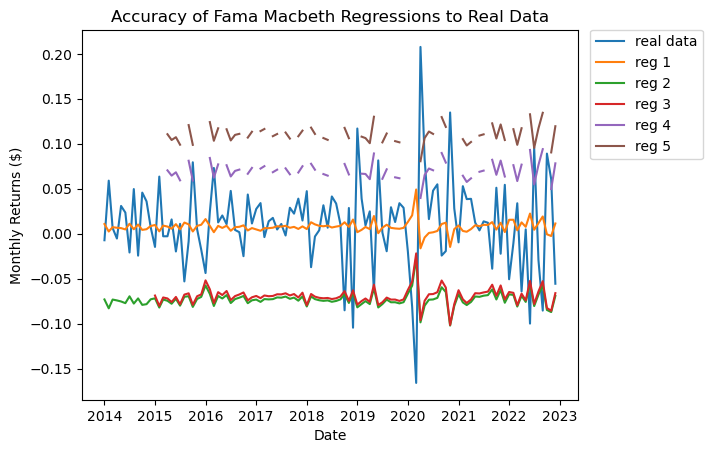

In [159]:
import matplotlib.pyplot as plt
plt.plot(np.mean(ret, axis = 1), label = 'real data')
plt.plot(r1+0.011393, label = 'reg 1')
plt.plot(r2+0.000021, label = 'reg 2')
plt.plot(r3+0.00002, label = 'reg 3')
plt.plot(r4+0.000012, label = 'reg 4')
plt.plot(r5+0.000012, label = 'reg 5')
plt.legend(loc = (1.025, 0.65))
plt.ylabel('Monthly Returns ($)')
plt.xlabel('Date')
plt.title('Accuracy of Fama Macbeth Regressions to Real Data')

In [156]:
final

,RET(1),RET(1),RET(1),RET(1),RET(1)
Intercept,0.011393,0.000021,0.00002,0.000012,0.000012
ABNR,-0.132714,-0.163552,-0.154541,-0.070110,
ABPR,0.076754,0.076068,0.048799,0.041582,
RET_CO_M,-0.208814,-0.249065,-0.266796,-0.330442,-0.31659
RET_OC_M,-0.035821,-0.064183,-0.069942,-0.153059,-0.161997
SIZE,,-0.00024,0.000385,0.003890,0.004341
BM,,-0.251103,-0.309875,-0.344313,-0.346777
RET_6M,,-0.14019,-0.194928,-0.229601,-0.225642
GPA,,,0.048799,0.041582,0.091394
ATGTH,,,-0.014257,-0.019576,-0.022252
